In [1]:
from typing import List, Callable

import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
from numpy.typing import NDArray
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

sns.set_theme()
sns.set(font_scale=1.3)


def generate_random_labels(
    n_samples: int, class_proportions: List[int], random_seed=None
) -> NDArray:
    assert np.sum(class_proportions) == 1

    rs = RandomState(MT19937(SeedSequence(random_seed)))

    labels = rs.rand(n_samples)
    n_classes = len(class_proportions)
    cum_props = np.cumsum([0, *class_proportions])
    for idx in range(0, n_classes):
        labels[
            np.logical_and(labels >= cum_props[idx], labels < cum_props[idx + 1])
        ] = idx

    return labels


def generate_random_predictions(
    y: NDArray, class_proportions: List[int], random_seed=None
) -> NDArray:
    n_samples = len(y)
    return generate_random_labels(n_samples, class_proportions, random_seed)


def simulate_random_classification_experiments(
    n_samples: int,
    n_iter: int,
    p_k_vec: List[float],
    p_k_hat_vec: List[float],
    metric: Callable,
) -> NDArray:
    scores = np.zeros((n_iter, len(p_k_vec), len(p_k_hat_vec)))
    for p_k_idx, p_k in enumerate(p_k_vec):
        for p_k_hat_idx, p_k_hat in enumerate(p_k_hat_vec):
            for iter_idx in range(n_iter):
                y = generate_random_labels(n_samples, [1 - p_k, p_k])
                y_hat = generate_random_predictions(y, [1 - p_k_hat, p_k_hat])
                scores[iter_idx, p_k_idx, p_k_hat_idx] = metric(y, y_hat)

    return scores


def simulate_random_classification_experiments_equalprob(
    n_samples: int,
    n_iter: int,
    p_vec: List[float],
    metric: Callable,
) -> NDArray:
    scores = np.zeros((n_iter, len(p_vec)))
    for p_idx, p in enumerate(p_k_vec):
        for iter_idx in range(n_iter):
            y = generate_random_labels(n_samples, [1 - p, p])
            y_hat = generate_random_predictions(y, [1 - p, p])
            scores[iter_idx, p_idx] = metric(y, y_hat)

    return scores


def plot_scores(x, scores, ax, xlabel, ylabel, title, widths=0.05):
    ax.boxplot(
        scores,
        positions=x,
        widths=widths,
        labels=[f"{p:.1f}" for p in x],
    )
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1))
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_aspect("equal")


## Confusion matrix

\begin{align*}
  TP &= p(y = k, \hat{y} = k) \\
     &= p(y = k)p(\hat{y} = k) \\
     &= pq \\
  TN &= p(y \neq k, \hat{y} \neq k) \\
     &= (1 - p(y = k))(1 - p(\hat{y} = k)) \\
     &= (1 - p)(1 - q) \\
  FP &= (1 - p)q \\
  FN &= p(1 - q)
\end{align*}

where $p: = p(y = k), q: = p(\hat{y} = k)$.

## Precision
\begin{align*}
  P &= \frac{TP}{TP + FP} \\
   &= \frac{pq}{pq + (1 - p)q} \\
   &= p
\end{align*}


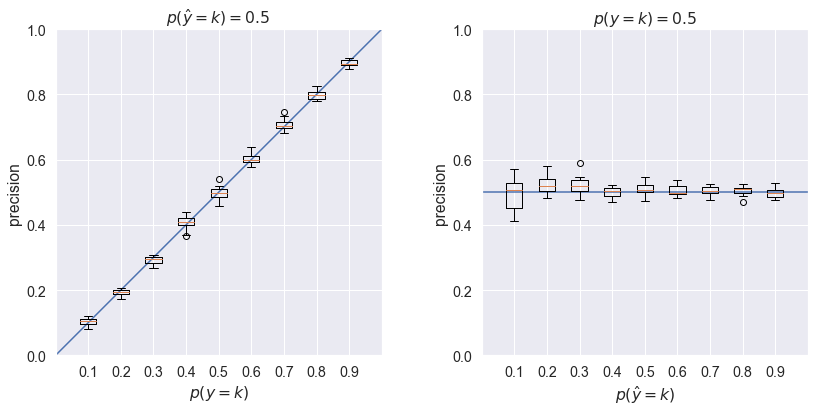

In [2]:
n_samples = 1000
n_iter = 10

# Varying p(y = k), keeping p(y_hat = k) constant
p_k_vec = np.arange(0.1, 1, 0.1)
p_k_hat = 0.5
varying_p_k_scores = simulate_random_classification_experiments(
    n_samples, n_iter, p_k_vec, [p_k_hat], precision_score
)

# Keeping p(y = k) constant, varying p(y_hat = k)
p_k = 0.5
p_k_hat_vec = np.arange(0.1, 1, 0.1)
varying_p_k_hat_scores = simulate_random_classification_experiments(
    n_samples, n_iter, [p_k], p_k_hat_vec, precision_score
)

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot([0, 1], [0, 1])
ax[1].axhline(p_k)
plot_scores(
    p_k_vec,
    varying_p_k_scores.squeeze(),
    ax[0],
    "$p(y = k)$",
    "precision",
    "$p(\hat{y} = k) = %.1f$" % p_k_hat,
)
plot_scores(
    p_k_hat_vec,
    varying_p_k_hat_scores.squeeze(),
    ax[1],
    "$p(\hat{y} = k)$",
    "precision",
    "$p(y = k) = %.1f$" % p_k,
)
plt.show()


## Recall 
\begin{align*}
  R &= \frac{TP}{TP + FN} \\
   &= \frac{pq}{pq + p(1 -q)} \\
   &= q
\end{align*}

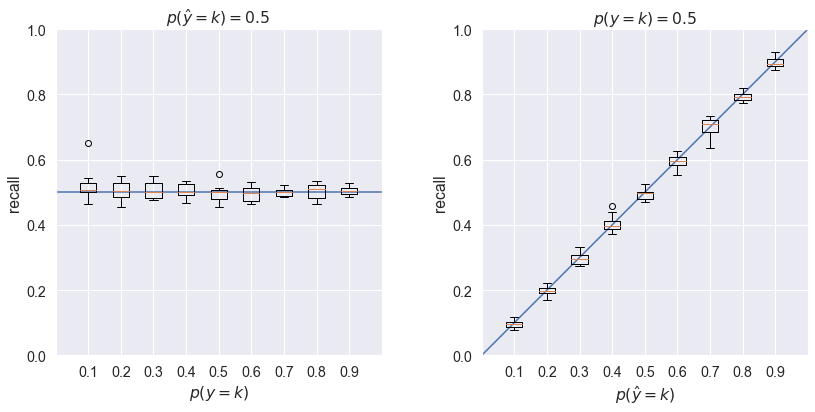

In [3]:
n_samples = 1000
n_iter = 10

# Varying p(y = k), keeping p(y_hat = k) constant
p_k_vec = np.arange(0.1, 1, 0.1)
p_k_hat = 0.5
varying_p_k_scores = simulate_random_classification_experiments(
    n_samples, n_iter, p_k_vec, [p_k_hat], recall_score
)

# Keeping p(y = k) constant, varying p(y_hat = k)
p_k = 0.5
p_k_hat_vec = np.arange(0.1, 1, 0.1)
varying_p_k_hat_scores = simulate_random_classification_experiments(
    n_samples, n_iter, [p_k], p_k_hat_vec, recall_score
)

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].axhline(p_k_hat)
ax[1].plot([0, 1], [0, 1])
plot_scores(
    p_k_vec,
    varying_p_k_scores.squeeze(),
    ax[0],
    "$p(y = k)$",
    "recall",
    "$p(\hat{y} = k) = %.1f$" % p_k_hat,
)
plot_scores(
    p_k_hat_vec,
    varying_p_k_hat_scores.squeeze(),
    ax[1],
    "$p(\hat{y} = k)$",
    "recall",
    "$p(y = k) = %.1f$" % p_k,
)
plt.show()


## F1 score
\begin{align*}
  f1 &= 2\frac{PR}{P + R} \\
   &= 2\frac{pq}{p + q}
\end{align*}

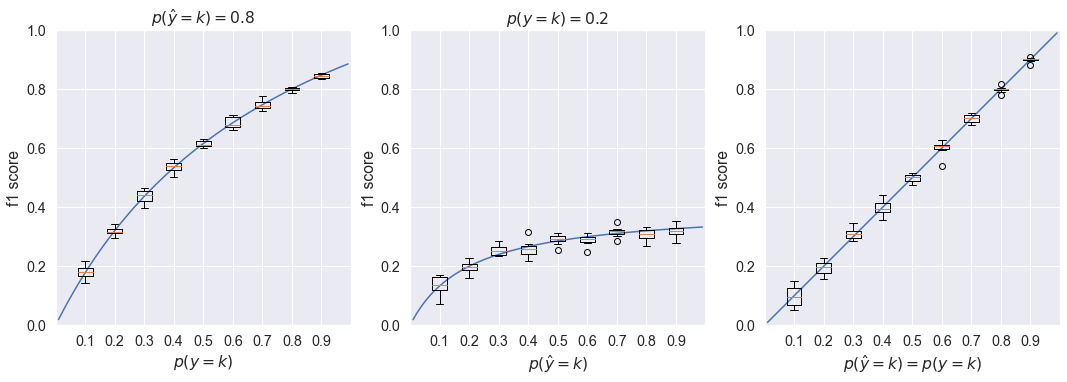

In [4]:
n_samples = 1000
n_iter = 10

# Varying p(y = k), keeping p(y_hat = k) constant
p_k_vec = np.arange(0.1, 1, 0.1)
p_k_hat = 0.8
varying_p_k_scores = simulate_random_classification_experiments(
    n_samples, n_iter, p_k_vec, [p_k_hat], f1_score
)

# Keeping p(y = k) constant, varying p(y_hat = k)
p_k = 0.2
p_k_hat_vec = np.arange(0.1, 1, 0.1)
varying_p_k_hat_scores = simulate_random_classification_experiments(
    n_samples, n_iter, [p_k], p_k_hat_vec, f1_score
)

# Varying p(y = k) = p(y_hat = k)
p_vec = np.arange(0.1, 1, 0.1)
varying_p_scores = simulate_random_classification_experiments_equalprob(
    n_samples, n_iter, p_vec, f1_score
)

# Plot results
f1 = lambda P, R: 2 * P * R / (P + R)
p_k_plot = np.arange(0.01, 1, 0.01)
p_k_hat_plot = np.arange(0.01, 1, 0.01)
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].plot(p_k_plot, f1(p_k_plot, p_k_hat))
ax[1].plot(p_k_hat_plot, f1(p_k, p_k_hat_plot))
ax[2].plot(p_k_hat_plot, f1(p_k_hat_plot, p_k_hat_plot))
plot_scores(
    p_k_vec,
    varying_p_k_scores.squeeze(),
    ax[0],
    "$p(y = k)$",
    "f1 score",
    "$p(\hat{y} = k) = %.1f$" % p_k_hat,
)
plot_scores(
    p_k_hat_vec,
    varying_p_k_hat_scores.squeeze(),
    ax[1],
    "$p(\hat{y} = k)$",
    "f1 score",
    "$p(y = k) = %.1f$" % p_k,
)
plot_scores(
    p_vec,
    varying_p_scores.squeeze(),
    ax[2],
    "$p(\hat{y} = k) = p(y = k)$",
    "f1 score",
    "",
)
plt.show()


## Accuracy
\begin{align*}
  ACC &= \frac{TP + TN}{TP + TN + FP + FN} \\
   &= \frac{pq + (1-p)(1-q)}{pq + (1-p)(1-q) + (1-p)q + p(1-q)} \\
   &= 1 + 2pq - p - q
\end{align*}

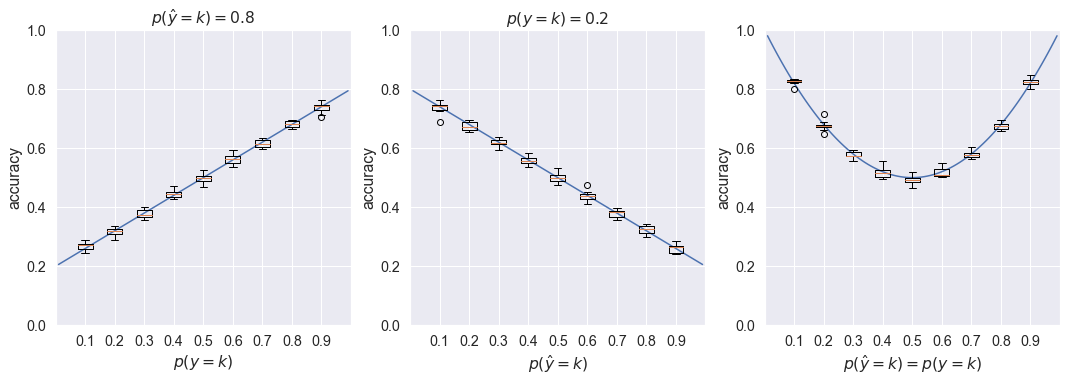

In [5]:
n_samples = 1000
n_iter = 10

# Varying p(y = k), keeping p(y_hat = k) constant
p_k_vec = np.arange(0.1, 1, 0.1)
p_k_hat = 0.8
varying_p_k_scores = simulate_random_classification_experiments(
    n_samples, n_iter, p_k_vec, [p_k_hat], accuracy_score
)

# Keeping p(y = k) constant, varying p(y_hat = k)
p_k = 0.2
p_k_hat_vec = np.arange(0.1, 1, 0.1)
varying_p_k_hat_scores = simulate_random_classification_experiments(
    n_samples, n_iter, [p_k], p_k_hat_vec, accuracy_score
)

# Varying p(y = k) = p(y_hat = k)
p_vec = np.arange(0.1, 1, 0.1)
varying_p_scores = simulate_random_classification_experiments_equalprob(
    n_samples, n_iter, p_vec, accuracy_score
)

# Plot results
acc = lambda p_k, p_k_hat: 1 + 2*p_k*p_k_hat - p_k - p_k_hat
p_k_plot = np.arange(0.01, 1, 0.01)
p_k_hat_plot = np.arange(0.01, 1, 0.01)
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].plot(p_k_plot, acc(p_k_plot, p_k_hat))
ax[1].plot(p_k_hat_plot, acc(p_k, p_k_hat_plot))
ax[2].plot(p_k_hat_plot, acc(p_k_hat_plot, p_k_hat_plot))
plot_scores(
    p_k_vec,
    varying_p_k_scores.squeeze(),
    ax[0],
    "$p(y = k)$",
    "accuracy",
    "$p(\hat{y} = k) = %.1f$" % p_k_hat,
)
plot_scores(
    p_k_hat_vec,
    varying_p_k_hat_scores.squeeze(),
    ax[1],
    "$p(\hat{y} = k)$",
    "accuracy",
    "$p(y = k) = %.1f$" % p_k,
)
plot_scores(
    p_vec,
    varying_p_scores.squeeze(),
    ax[2],
    "$p(\hat{y} = k) = p(y = k)$",
    "accuracy",
    "",
)
plt.show()


## ROC-AUC

\begin{align*}
  TPR &= q \\
  FPR &= \frac{FP}{FP + TN} \\
      &= \frac{(1-p)q}{(1-p)q + (1-p)(1-q)}
      &= q \\
  AUC &= \frac{1}{2}
\end{align*}

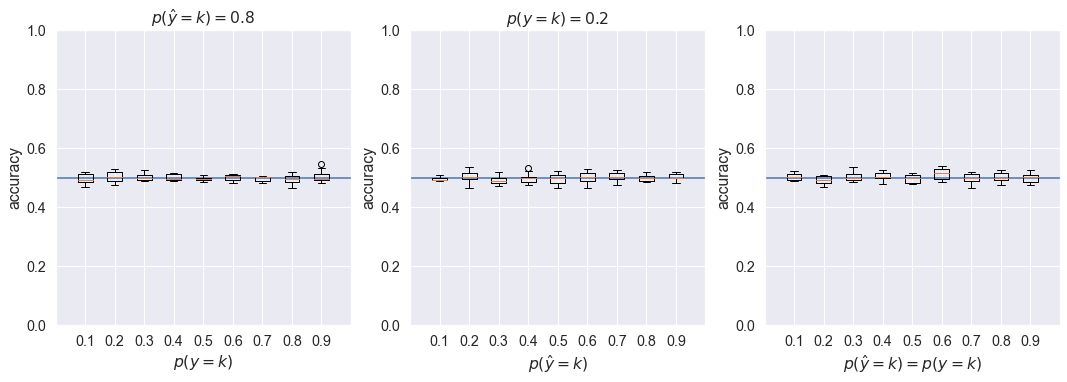

In [6]:
n_samples = 1000
n_iter = 10

# Varying p(y = k), keeping p(y_hat = k) constant
p_k_vec = np.arange(0.1, 1, 0.1)
p_k_hat = 0.8
varying_p_k_scores = simulate_random_classification_experiments(
    n_samples, n_iter, p_k_vec, [p_k_hat], roc_auc_score
)

# Keeping p(y = k) constant, varying p(y_hat = k)
p_k = 0.2
p_k_hat_vec = np.arange(0.1, 1, 0.1)
varying_p_k_hat_scores = simulate_random_classification_experiments(
    n_samples, n_iter, [p_k], p_k_hat_vec, roc_auc_score
)

# Varying p(y = k) = p(y_hat = k)
p_vec = np.arange(0.1, 1, 0.1)
varying_p_scores = simulate_random_classification_experiments_equalprob(
    n_samples, n_iter, p_vec, roc_auc_score
)

# Plot results
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].axhline(0.5)
ax[1].axhline(0.5)
ax[2].axhline(0.5)
plot_scores(
    p_k_vec,
    varying_p_k_scores.squeeze(),
    ax[0],
    "$p(y = k)$",
    "accuracy",
    "$p(\hat{y} = k) = %.1f$" % p_k_hat,
)
plot_scores(
    p_k_hat_vec,
    varying_p_k_hat_scores.squeeze(),
    ax[1],
    "$p(\hat{y} = k)$",
    "accuracy",
    "$p(y = k) = %.1f$" % p_k,
)
plot_scores(
    p_vec,
    varying_p_scores.squeeze(),
    ax[2],
    "$p(\hat{y} = k) = p(y = k)$",
    "accuracy",
    "",
)
plt.show()